## Import Libraries ##

In [1]:
# utility libraries
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import random
import math

# preprocessing and fine tuning libraries
from sklearn.preprocessing import StandardScaler
# cross val
# grid search
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.base import clone
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

# Machine learning algorithms
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.cluster import KMeans


# Ensure output consistency of notebook
rnd_state = 42
np.random.seed(rnd_state)
random.seed(rnd_state)

In [2]:
# Names of features in the data
col_names = ['NS', 'IPC', 'BRhits', 'BRmiss', 'DRAMreq', 
             'DRAMrd', 'DRAMwr', 'DTLBacc', 'DTLBmiss', 'ITLBacc',
            'ITLBmiss', 'STLBacc', 'STLBmiss', 'DL1ld', 'DL1miss',
            'DL1st', 'IL1ld', 'IL1miss', 'IL1st', 'L2ld',
            'L2miss', 'L2st', 'L3ld', 'L3miss', 'L3st',
            'uopBR', 'uopFPaddsub', 'uopFPmuldiv', 'uopGeneric', 'uopLD',
            'uopST', 'uopTotal']

## Load Data ##

In [3]:
CUR_PATH = os.getcwd()

def combined_load_data(dir_list, path=CUR_PATH):
    path = path + '/' + dir_list
    all_files_df = []
    all_num_samples = []
    for filename in glob.glob(os.path.join(path, '*.stats')):
        df = pd.read_csv(filename, header=None, names=col_names, delim_whitespace=True)
        bmk_name = dir_list + '_' + filename.replace(path, '').replace('/pinned', '').replace('.stats', '')
        df['Bmk_Name'] = bmk_name
        print(bmk_name , df.shape[0])
        all_num_samples.append(df.shape[0])
        all_files_df.append(df)
    print('Average num of samples per bmk:',sum(all_num_samples)//len(all_num_samples))
    print('Number of combined bmk files:', len(all_files_df), '\n')
    return all_files_df

def create_train_test_sets(file_df_list, test_ratio):
    n_test = math.floor(len(file_df_list)*test_ratio)
    # Shuffle the order of the data set
    #random.seed(rnd_state)
    random.Random(rnd_state).shuffle(file_df_list)
    test_df_list = file_df_list[:n_test]
    train_df_list = file_df_list[n_test:]
    return train_df_list,test_df_list
                         
def combine_data_files_to_df(all_files):
    print('Number of combined bmk files:', len(all_files))
    frame = pd.DataFrame(pd.concat(all_files))
    # Remove useless instruction store feature
    #frame = frame.drop('IL1st',1)
    print('Shape of loaded dataframe:', frame.shape)
    return frame

In [4]:
# SPLIT TRAIN TEST SETS
data_dir = {'spec':'SPEC2006', 'splash':'SPLASH2'}

In [5]:
spec_data_list = combined_load_data(data_dir['spec'])
splash_data_list = combined_load_data(data_dir['splash'])

SPEC2006_libquantum 473
SPEC2006_gcc 193
SPEC2006_GemsFDTD 327
SPEC2006_cactusADM 146
SPEC2006_sjeng 196
SPEC2006_lbm 244
SPEC2006_gamess 107
SPEC2006_bzip2 202
SPEC2006_namd 91
SPEC2006_tonto 116
SPEC2006_perlbench 129
SPEC2006_bwaves 230
SPEC2006_mcf 287
SPEC2006_gobmk 239
SPEC2006_leslie3d 282
SPEC2006_xalancbmk 138
SPEC2006_milc 310
SPEC2006_h264ref 110
SPEC2006_zeusmp 117
SPEC2006_povray 170
SPEC2006_hmmer 91
SPEC2006_astar 261
SPEC2006_soplex 279
SPEC2006_gromacs 98
SPEC2006_omnetpp 347
SPEC2006_calculix 103
Average num of samples per bmk: 203
Number of combined bmk files: 26 

SPLASH2_lu.ncont 509
SPLASH2_fft 824
SPLASH2_ocean.cont 2826
SPLASH2_lu.cont 472
SPLASH2_cholesky 206
SPLASH2_water.sp 391
SPLASH2_barnes 1866
SPLASH2_radiosity 2633
SPLASH2_radix 155
SPLASH2_ocean.ncont 3122
SPLASH2_water.nsq 1422
SPLASH2_raytrace 944
SPLASH2_fmm 785
Average num of samples per bmk: 1242
Number of combined bmk files: 13 



In [6]:
# SEPARATE DATA INTO TRAIN AND TEST SETS BASED ON 80%-20% SPLIT OF BENCHMARKS
test_ratio = 0.3
spec_train_list, spec_test_list =  create_train_test_sets(spec_data_list, test_ratio)
splash_train_list, splash_test_list =  create_train_test_sets(splash_data_list, test_ratio)

print(len(spec_test_list),len(splash_test_list))
print(len(spec_train_list),len(splash_train_list))

7 3
19 10


In [7]:
def print_data_set_bmk_names(l):
    print('Num bmks:',len(l))
    for i in l:
        print(i['Bmk_Name'][0])
    print('\n\n')
print('SPLASH-2 Train Benchmarks:')
print_data_set_bmk_names(splash_train_list)
print('SPLASH-2 Test Benchmarks:')
print_data_set_bmk_names(splash_test_list)
print('SPEC2006 Train Benchmarks:')
print_data_set_bmk_names(spec_train_list)
print('SPEC2006 Test Benchmarks:')
print_data_set_bmk_names(spec_test_list)


SPLASH-2 Train Benchmarks:
Num bmks: 10
SPLASH2_ocean.ncont
SPLASH2_fmm
SPLASH2_water.sp
SPLASH2_raytrace
SPLASH2_radix
SPLASH2_lu.cont
SPLASH2_cholesky
SPLASH2_lu.ncont
SPLASH2_fft
SPLASH2_water.nsq



SPLASH-2 Test Benchmarks:
Num bmks: 3
SPLASH2_radiosity
SPLASH2_barnes
SPLASH2_ocean.cont



SPEC2006 Train Benchmarks:
Num bmks: 19
SPEC2006_perlbench
SPEC2006_xalancbmk
SPEC2006_soplex
SPEC2006_bwaves
SPEC2006_zeusmp
SPEC2006_gcc
SPEC2006_leslie3d
SPEC2006_gromacs
SPEC2006_gobmk
SPEC2006_GemsFDTD
SPEC2006_h264ref
SPEC2006_omnetpp
SPEC2006_sjeng
SPEC2006_astar
SPEC2006_bzip2
SPEC2006_namd
SPEC2006_libquantum
SPEC2006_cactusADM
SPEC2006_hmmer



SPEC2006 Test Benchmarks:
Num bmks: 7
SPEC2006_milc
SPEC2006_mcf
SPEC2006_tonto
SPEC2006_calculix
SPEC2006_povray
SPEC2006_gamess
SPEC2006_lbm





In [8]:
train_df = combine_data_files_to_df(splash_train_list+spec_train_list)
test_df = combine_data_files_to_df(splash_test_list+spec_test_list)

Number of combined bmk files: 29
Shape of loaded dataframe: (12779, 33)
Number of combined bmk files: 10
Shape of loaded dataframe: (8662, 33)


In [9]:
# Randomize train dataset
#data_df = data_df.sample(frac=1).reset_index(drop=True)
train_df = train_df.sample(frac=1).reset_index(drop=True)

In [ ]:
# Reload data frame from backup copy if needed
#train_df = train_df_copy.copy()

In [9]:
#data_df = data_df.drop('NS',1)
#test_data_df = test_data_df.drop('NS',1)

## Explore the Data ##

In [10]:
# Define useful functions

# Explore individual correlations
def explore_indv_corr(df,focus_cols=['IPC']):
    idv_corrs = df.corr().filter(focus_cols).drop(focus_cols).sort_values(by=['IPC'],ascending=False)
    print('One to One Correlations')
    #print(idv_corrs)
    return idv_corrs

# Explore feature correlation heatmap
def corr_heatmap(df, save_name = 'corr_heatmap.png'):
    plt.figure(figsize = (10,7))
    corr = df.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, annot=True, mask=mask, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)
    plt.savefig(save_name)
    plt.show()
    
# Find redundant features
# Taken from arun's answer in: https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    #print(len(labels_to_drop))
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    print("Top Absolute Correlations")
    print(au_corr[0:n])
    return au_corr[0:n]

def helper_remove_redundant_features(df,redundant_features):
    for i in redundant_features:
        print('Removing redundant feature:',i[0])
        #new_label = i[0]+'_'+i[1]
        df = df.drop(i[0],1)
        #d = {i[1]: new_label}
        #df.rename(columns=d, inplace = True)
    return df

def remove_redundant_features(df, n_top_corrs, redundant_threshold, verbose=True):
    # Remove redundant features
    redundant_features = []
    top_corrs = get_top_abs_correlations(df, n_top_corrs)
    if verbose:
        print('\nPre filtering dataframe shape and features:\n', df.shape,'\n',df.columns,'\n')
    for i,j in top_corrs.iteritems():
        if j > redundant_threshold:
            print('Redundant features:',i, ' with corr:',j)
            redundant_features.append(i)
            #print('Combining features:',i, ' with corr:',j)
            #new_label = i[0]+'_'+i[1]
            #print(new_label)
            #df = df.drop(i[0],1)
            #d = {i[1]: new_label}
            #print('d',d)
            #df.rename(columns=d, inplace = True)
    df = helper_remove_redundant_features(df,redundant_features)
    if verbose:
        print('\nPost filtering dataframe shape and features:\n', df.shape,'\n',df.columns)
    return df, redundant_features

*** Reduce data set to set of attributes within scope of work ***

In [11]:
explore_indv_corr(train_df)

One to One Correlations


,IPC
uopTotal,0.985197
uopGeneric,0.904738
ITLBacc,0.851062
IL1ld,0.851062
uopLD,0.778307
DL1ld,0.778249
DTLBacc,0.774898
BRhits,0.712404
uopBR,0.669393
uopFPmuldiv,0.662094


In [12]:
# combine FP ops into one attribute
train_df['uopFP'] = train_df['uopFPaddsub'] + train_df['uopFPmuldiv']
test_df['uopFP'] = test_df['uopFPaddsub'] + test_df['uopFPmuldiv']

In [13]:
statistic_drop_list = ['NS','Bmk_Name','BRhits', 'DRAMreq', 'uopTotal',
             'DRAMrd', 'DRAMwr', 'DTLBacc', 'DTLBmiss', 'ITLBacc',
            'ITLBmiss', 'STLBmiss', 'DL1ld','uopFPaddsub', 'uopFPmuldiv',
            'DL1st', 'IL1st', 'L2ld',
            'L2st', 'L3ld', 'L3st',  'uopGeneric']

In [14]:
# Reduce attributes
print('Original training data set shape and attributes:\n', train_df.shape,'\n',
      'num attributes:', len(train_df.columns), '\n',
      train_df.columns,'\n')

reduced_train_df = train_df.drop(statistic_drop_list,1)
reduced_test_df = test_df.drop(statistic_drop_list,1)
print('Reduced training data set shape and attributes:\n', reduced_train_df.shape,'\n',
      'num attributes:', len(reduced_train_df.columns), '\n',
      reduced_train_df.columns,'\n')



Original training data set shape and attributes:
 (12779, 34) 
 num attributes: 34 
 Index(['NS', 'IPC', 'BRhits', 'BRmiss', 'DRAMreq', 'DRAMrd', 'DRAMwr',
       'DTLBacc', 'DTLBmiss', 'ITLBacc', 'ITLBmiss', 'STLBacc', 'STLBmiss',
       'DL1ld', 'DL1miss', 'DL1st', 'IL1ld', 'IL1miss', 'IL1st', 'L2ld',
       'L2miss', 'L2st', 'L3ld', 'L3miss', 'L3st', 'uopBR', 'uopFPaddsub',
       'uopFPmuldiv', 'uopGeneric', 'uopLD', 'uopST', 'uopTotal', 'Bmk_Name',
       'uopFP'],
      dtype='object') 

Reduced training data set shape and attributes:
 (12779, 12) 
 num attributes: 12 
 Index(['IPC', 'BRmiss', 'STLBacc', 'DL1miss', 'IL1ld', 'IL1miss', 'L2miss',
       'L3miss', 'uopBR', 'uopLD', 'uopST', 'uopFP'],
      dtype='object') 



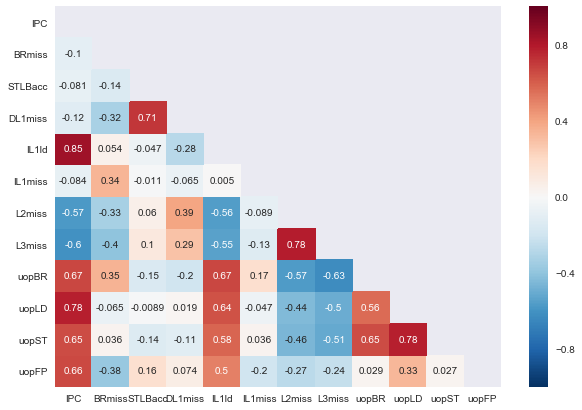

In [15]:
corr_heatmap(reduced_train_df)

In [16]:
# Examine IPC attribute correlations with all other attributes
explore_indv_corr(reduced_train_df)

One to One Correlations


,IPC
IL1ld,0.851062
uopLD,0.778307
uopBR,0.669393
uopFP,0.659871
uopST,0.650803
STLBacc,-0.081274
IL1miss,-0.083647
BRmiss,-0.100201
DL1miss,-0.118891
L2miss,-0.571348


In [17]:
train_df_condensed, redundant_features = remove_redundant_features(reduced_train_df, n_top_corrs=35, redundant_threshold=0.995)

Top Absolute Correlations
IPC      IL1ld      0.851062
L2miss   L3miss     0.781442
uopLD    uopST      0.780728
IPC      uopLD      0.778307
STLBacc  DL1miss    0.711031
IL1ld    uopBR      0.669586
IPC      uopBR      0.669393
         uopFP      0.659871
uopBR    uopST      0.654785
IPC      uopST      0.650803
IL1ld    uopLD      0.636653
L3miss   uopBR      0.631215
IPC      L3miss     0.602617
IL1ld    uopST      0.583388
IPC      L2miss     0.571348
L2miss   uopBR      0.569766
uopBR    uopLD      0.563215
IL1ld    L2miss     0.555743
         L3miss     0.545821
L3miss   uopST      0.509051
IL1ld    uopFP      0.502835
L3miss   uopLD      0.498295
L2miss   uopST      0.457696
         uopLD      0.438236
BRmiss   L3miss     0.400955
DL1miss  L2miss     0.391849
BRmiss   uopFP      0.376083
         uopBR      0.349369
         IL1miss    0.340210
         L2miss     0.331397
uopLD    uopFP      0.328725
BRmiss   DL1miss    0.321266
DL1miss  L3miss     0.290854
         IL1ld   

In [18]:
print(redundant_features)

[]


In [19]:
test_df_condensed = helper_remove_redundant_features(reduced_test_df, redundant_features)

In [20]:
print(len(test_df_condensed.columns))
print(test_df_condensed.columns)

12
Index(['IPC', 'BRmiss', 'STLBacc', 'DL1miss', 'IL1ld', 'IL1miss', 'L2miss',
       'L3miss', 'uopBR', 'uopLD', 'uopST', 'uopFP'],
      dtype='object')


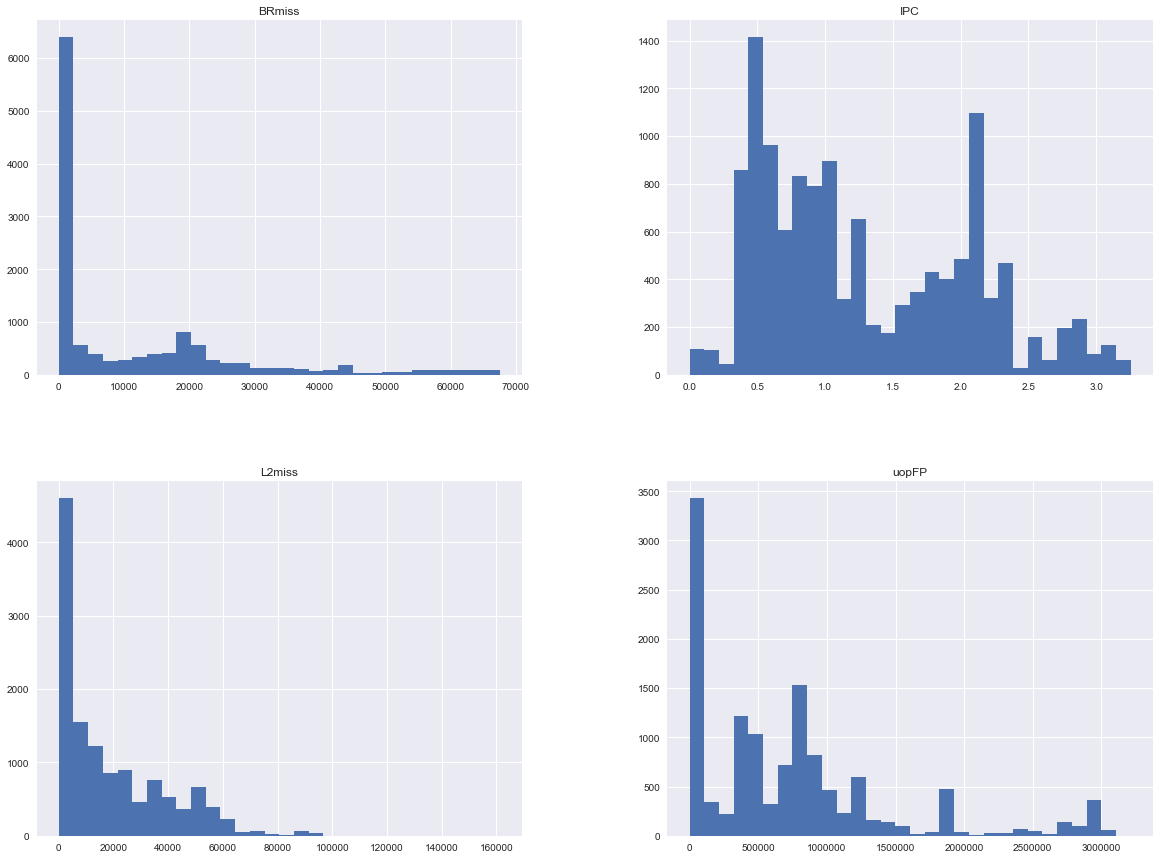

In [21]:
col_of_interest = ['IPC', 'L2miss', 'BRmiss', 'uopFP']
# 'uopBR', 'uopFPaddsub', 'uopFPmuldiv', 'uopGeneric', 'uopLD',
#            'uopST', 'uopTotal']
        
reduced_train_df[col_of_interest].hist(bins=30, figsize=(20,15))
#save_fig("attribute_histogram_plots")
plt.savefig('stat_histograms.png')
plt.show()

In [22]:
# Create X and y datasets ready for machine learning algorithms
y = reduced_train_df['IPC']
X = reduced_train_df.drop('IPC',1)

y_test = reduced_test_df['IPC']
X_test = reduced_test_df.drop('IPC',1)

In [23]:
# Compare shapes of unfiltered df, filtered df, and ratio df 
print('Train X shape:', X.shape)
print('Train y shape:', y.shape)

print('Test X shape:', X_test.shape)
print('Test y shape:', y_test.shape)

Train X shape: (12779, 11)
Train y shape: (12779,)
Test X shape: (8662, 11)
Test y shape: (8662,)


In [21]:
# Examine y targets
#print('IPC samples:')
#print(y)

In [24]:
# Check is any values are missing
print(X.isnull().values.any())
print(X_test.isnull().values.any())

False
False


In [23]:
# Fill null values with zeros
#X_ratio = X_ratio.fillna(0)
#X_ratio.info()

In [25]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12779 entries, 0 to 12778
Data columns (total 11 columns):
BRmiss     12779 non-null float64
STLBacc    12779 non-null float64
DL1miss    12779 non-null float64
IL1ld      12779 non-null float64
IL1miss    12779 non-null float64
L2miss     12779 non-null float64
L3miss     12779 non-null float64
uopBR      12779 non-null float64
uopLD      12779 non-null float64
uopST      12779 non-null float64
uopFP      12779 non-null float64
dtypes: float64(11)
memory usage: 1.1 MB


In [26]:
# Normalize values
def normalize_df(train_df, test_df, verbose=False):
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(train_df.values)
    if verbose:
        print(scaler.mean_)
    rtn_train_df = pd.DataFrame(scaled_features, index=train_df.index, columns=train_df.columns)
    scaled_features_test = scaler.transform(test_df.values)
    rtn_test_df = pd.DataFrame(scaled_features_test, index=test_df.index, columns=test_df.columns)
    return rtn_train_df, rtn_test_df

In [27]:
X, X_test =  normalize_df(X, X_test)

In [28]:
X.head()

,BRmiss,STLBacc,DL1miss,IL1ld,IL1miss,L2miss,L3miss,uopBR,uopLD,uopST,uopFP
0,0.473615,-0.307727,-0.385164,-0.711368,-0.246151,0.347283,0.753707,-0.540146,-1.255357,-1.190844,-0.977315
1,-0.722616,-0.298099,-0.477948,-1.536043,-0.236878,0.131515,0.501880,-0.664001,-1.345446,0.089906,-0.977315
2,0.477681,-0.225141,-0.116703,-0.279737,-0.030419,-0.552603,-0.697559,-0.144691,-0.224249,-0.391204,-0.334039
3,-0.722616,-0.311600,-0.656506,1.889675,-0.237969,-0.549726,-0.725267,1.238727,1.486882,1.881951,0.096537
4,-0.678257,-0.243918,0.722864,-0.647051,0.407044,1.316381,0.657044,-0.943284,0.208304,-0.175209,-0.197964


## Machine learning models ##

In [29]:
for attr_name in X:
        print(attr_name, X[attr_name].shape)
print(y.shape)

BRmiss (12779,)
STLBacc (12779,)
DL1miss (12779,)
IL1ld (12779,)
IL1miss (12779,)
L2miss (12779,)
L3miss (12779,)
uopBR (12779,)
uopLD (12779,)
uopST (12779,)
uopFP (12779,)
(12779,)


In [45]:
# Useful functions
def lin_ref_func(X,y):
    lin_reg = LinearRegression()
    lin_reg.fit(X, y)
    #model_rmse_score(lin_reg,X,y)
    return lin_reg
    
def model_rmse_score(model,X,y):
    preds = model.predict(X)
    mse = mean_squared_error(y, preds)
    rmse = np.sqrt(mse)
    print('RMSE:', rmse)
    return rmse

def all_indv_lin_reg_scores(X,y,X_test,y_test):
    '''runs linear regression on all attributes one by one 
    independently vs IPC nand outputs their RMSE score on 
    the train and test sets'''
    indv_rmse_train_scores = []
    indv_rmse_test_scores = []
    for attr_name in X:
        print('Attribute:',attr_name)
        x_indv = X.as_matrix(columns=[attr_name])
        x_test_indv = X_test.as_matrix(columns=[attr_name])
        #indv_lin_reg = lin_ref_func(x_indv,y)
        indv_lin_reg = LinearRegression()
        indv_lin_reg.fit(x_indv, y)
        print('Train RMSE')
        indv_rmse_train_scores.append(model_rmse_score(indv_lin_reg,x_indv,y))
        print('Test RMSE')
        indv_rmse_test_scores.append(model_rmse_score(indv_lin_reg,x_test_indv,y_test))
        # Plot outputs
        y_test_pred = indv_lin_reg.predict(x_test_indv)
        y_pred = indv_lin_reg.predict(x_indv)
        plt.figure(figsize = (10,7))
        #plt.scatter(x_test_indv, y_test, marker='o', color='red')
        plt.scatter(x_indv, y, marker='x', color='green')
        plt.plot(x_indv, y_pred, color='blue', linewidth=3)
        #plt.plot(x_test_indv, y_test_pred, color='blue', linewidth=3)
        plt.title('Linear regression - ' + attr_name + ' vs IPC')
        plt.xlabel('Attribute value')
        plt.ylabel('IPC')
        plt.legend(['Prediction line','Train instance'])
        #plt.legend(['Prediction line', 'Test instance','Train instance'])
        #plt.xticks(ind, list(X.columns))
        plt.xticks(())
        plt.yticks(())
        plt.savefig(attr_name+'_lin_reg_plot.png')
        plt.show()

    ind = np.arange(len(X.columns))
    plt.figure(figsize = (10,7))
    plt.ylabel('RMSE')
    plt.title('Linear regression of individual attributes')
    plt.xticks(ind, list(X.columns),rotation='vertical')
    plt.plot(ind,indv_rmse_train_scores, 'g^')
    plt.plot(ind,indv_rmse_test_scores, 'bs')
    plt.legend(['Train', 'Test'])
    plt.savefig('ALL_lin_reg_plot.png')
    plt.show()


def find_best_model(model, param_grid, X, y, cv=5, verbose=True):
    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='neg_mean_squared_error', return_train_score=True)
    grid_search.fit(X, y)
    print('\nBest params:', grid_search.best_params_)
    #print('Best estimator:', grid_search.best_estimator_)
    if verbose:
        print('Results for gridsearch')
        cvres = grid_search.cv_results_
        for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
            print(np.sqrt(-mean_score), params)
    return grid_search.best_estimator_

def show_train_test_rmse_scores(model, X, y, X_test, y_test, data_dir, name):
    print('\nMODEL:', name)
    print('\nTRAIN RESULTS:')
    model_rmse_score(model,X,y)
    print('\nVALIDATION RESULTS:')
    print(np.mean(np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5))))
    print('\nTEST RESULTS:')
    model_rmse_score(model,X_test,y_test)
    print('\n')
    
def full_train_test_fit_score(model, param_grid, X, X_test, y, y_test, data_dir, name, verbose=False):
    model_opt = find_best_model(model, param_grid, X, y, verbose=verbose)
    show_train_test_rmse_scores(model_opt, X, y, X_test, y_test, data_dir, name)
    return model_opt

def plot_feature_importances(clf,df,save_name = 'feature_importance.png'):
    features = df.columns
    importances = clf.feature_importances_
    indices = np.argsort(importances)
    plt.figure(figsize = (10,7))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), features[indices])
    plt.xlabel('Relative Importance')
    plt.savefig(save_name)
    plt.show()
    
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=5,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5),
                        save_name = 'learning_curve.png'):
    # Taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
   
    plt.figure(figsize = (10,7))
    #plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("RMSE")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=n_jobs, train_sizes=train_sizes)
    # RMSE scores
    #train_scores_mean = np.sqrt(-np.mean(train_scores, axis=1))
    #train_scores_std = np.std(train_scores, axis=1)
    #test_scores_mean = np.sqrt(-np.mean(test_scores, axis=1))
    #test_scores_std = np.std(test_scores, axis=1)
    train_scores_mean = np.mean(np.sqrt(-train_scores), axis=1)
    train_scores_std = np.std(np.sqrt(-train_scores), axis=1)
    test_scores_mean = np.mean(np.sqrt(-test_scores), axis=1)
    test_scores_std = np.std(np.sqrt(-test_scores), axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.savefig(save_name)
    plt.show()
    return plt


def plot_validation_curve(estimator, title, X, y, param_name, param_range, ylim=None, cv=5,
                         save_name='validation_curve.png', is_ann=False):
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring='neg_mean_squared_error', n_jobs=1)
    train_scores_mean = np.mean(np.sqrt(-train_scores), axis=1)
    train_scores_std = np.std(np.sqrt(-train_scores), axis=1)
    test_scores_mean = np.mean(np.sqrt(-test_scores), axis=1)
    test_scores_std = np.std(np.sqrt(-test_scores), axis=1)

    plt.figure(figsize = (10,7))
    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("RMSE")
    if ylim is not None:
        plt.ylim(*ylim)
    plt.grid()
    if is_ann:
        #usually an ANN
        param_range = range(len(param_range))
        my_xticks = ['(2,)', '(6,)', '(25,)', '(100,)', '(6,6)', '(25,5)', '(10,10)']
        plt.xticks(param_range, my_xticks)
    
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange")
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="darkorange")
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy")
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="navy")
    #plt.xscale('linear')
    #plt.xticks(np.arange(len(param_range)), param_range)
    plt.legend(loc="best")
    plt.savefig(save_name)
    plt.show()
    return plt



### Linear Regression ###

Attribute: BRmiss
Train RMSE
RMSE: 0.7572002497411505
Test RMSE
RMSE: 0.5652731017471657


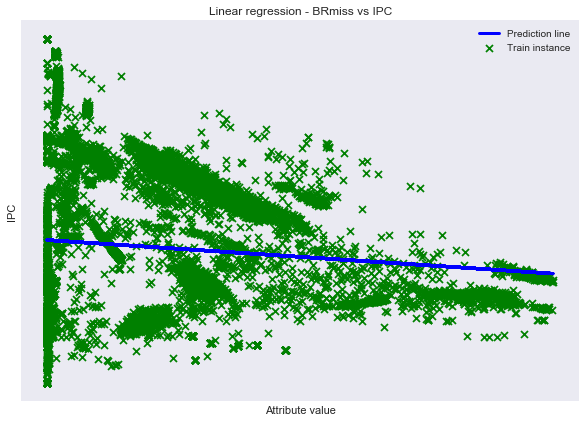

Attribute: STLBacc
Train RMSE
RMSE: 0.7585126968984436
Test RMSE
RMSE: 0.5625556436544072


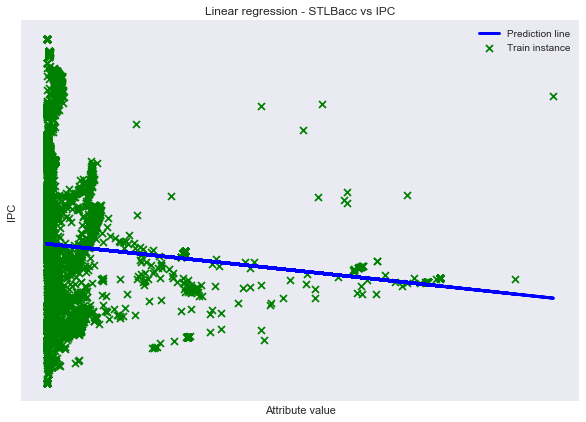

Attribute: DL1miss
Train RMSE
RMSE: 0.7556325499561233
Test RMSE
RMSE: 0.5628240314220975


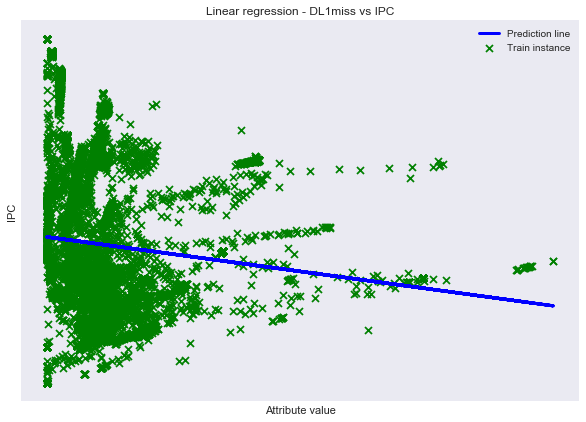

Attribute: IL1ld
Train RMSE
RMSE: 0.3995905223241435
Test RMSE
RMSE: 0.28509801201647417


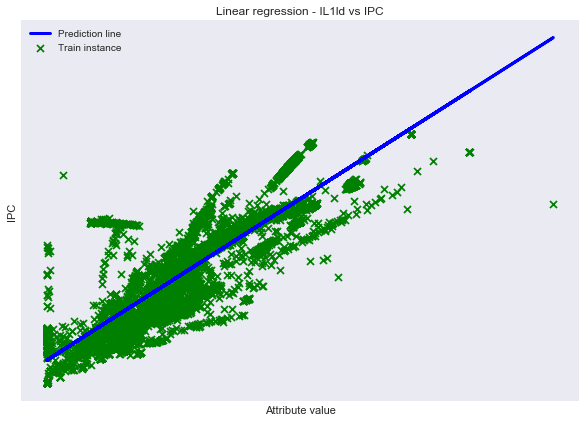

Attribute: IL1miss
Train RMSE
RMSE: 0.7583632421094391
Test RMSE
RMSE: 0.5627092671889313


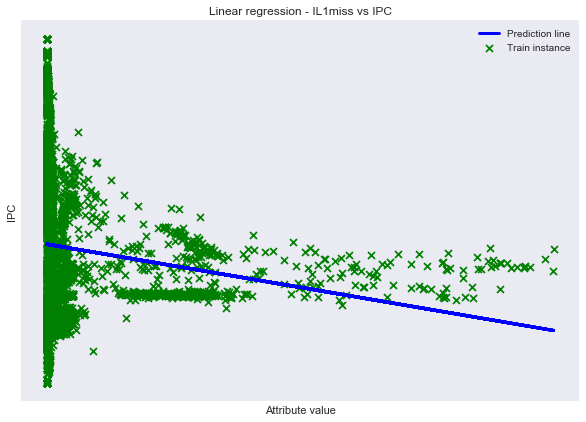

Attribute: L2miss
Train RMSE
RMSE: 0.6245836696305417
Test RMSE
RMSE: 0.6738514764705322


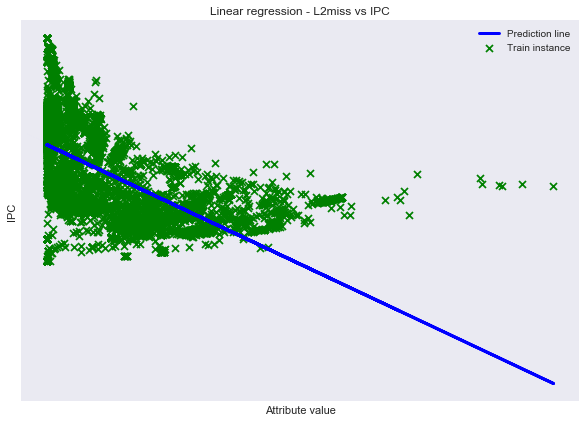

Attribute: L3miss
Train RMSE
RMSE: 0.6073255923036542
Test RMSE
RMSE: 0.5962062071897691


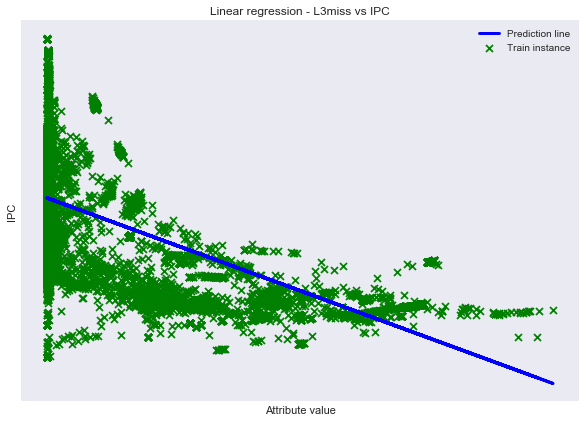

Attribute: uopBR
Train RMSE
RMSE: 0.5653759968630506
Test RMSE
RMSE: 0.36091915698057037


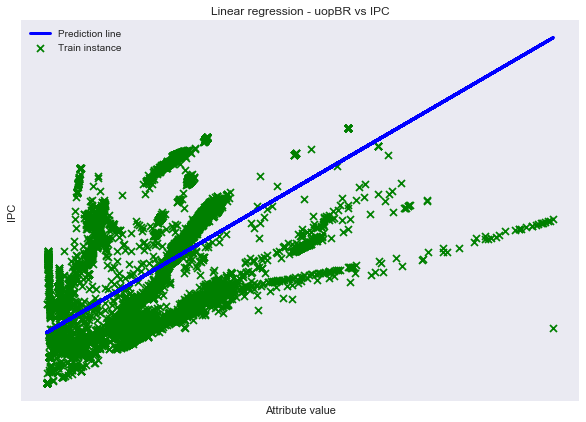

Attribute: uopLD
Train RMSE
RMSE: 0.4778388588160074
Test RMSE
RMSE: 0.30053587513910424


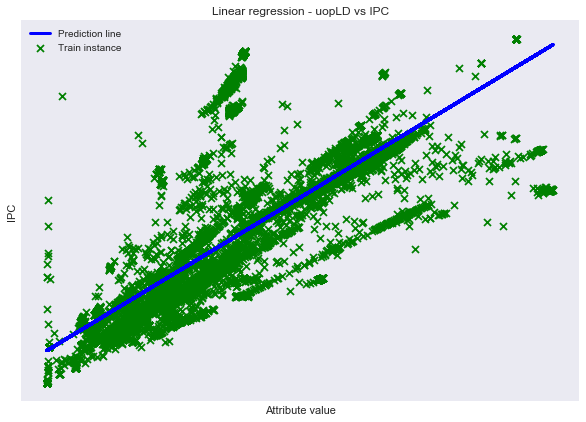

Attribute: uopST
Train RMSE
RMSE: 0.5778098083704445
Test RMSE
RMSE: 0.5020930534239625


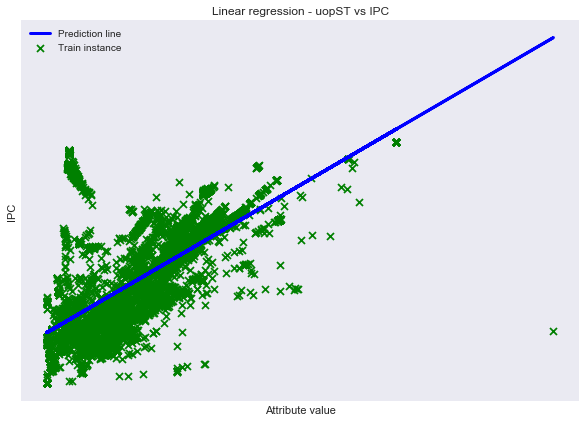

Attribute: uopFP
Train RMSE
RMSE: 0.571821817324647
Test RMSE
RMSE: 0.46227078341003547


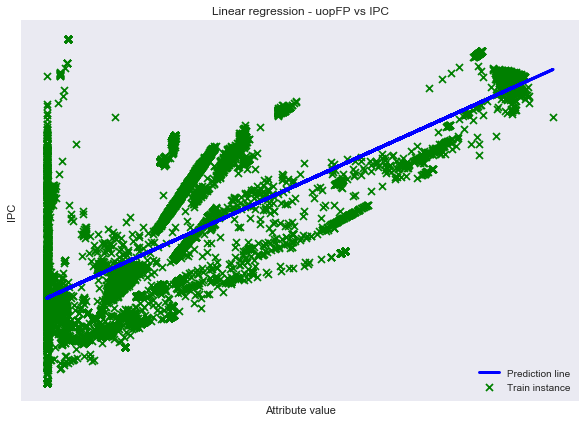

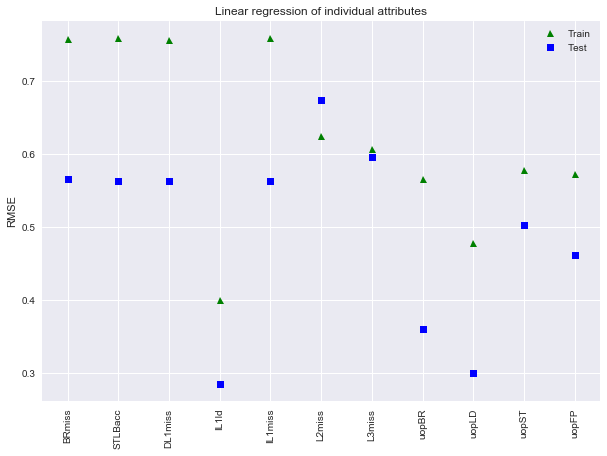

In [48]:
all_indv_lin_reg_scores(X,y,X_test,y_test)


In [54]:
def get_specific_lin_model_result(X, y, X_test, y_test, lin_attr_name = 'IL1ld'):
    x_indv = X.as_matrix(columns=[lin_attr_name])
    x_test_indv = X_test.as_matrix(columns=[lin_attr_name])
    indv_lin_reg = LinearRegression()
    indv_lin_reg.fit(x_indv, y)
    print('Train RMSE')
    model_rmse_score(indv_lin_reg,x_indv,y)
    print('Test RMSE')
    model_rmse_score(indv_lin_reg,x_test_indv,y_test)
    print('LinReg Model coefficient:', indv_lin_reg.coef_, 'intercept:', indv_lin_reg.intercept_)
get_specific_lin_model_result(X, y, X_test, y_test)

Train RMSE
RMSE: 0.3995905223241435
Test RMSE
RMSE: 0.28509801201647417
LinReg Model coefficient: [0.647684] intercept: 1.2924919007747087


In [32]:
lin_reg = lin_ref_func(X,y)
show_train_test_rmse_scores(lin_reg, X, y, X_test, y_test, data_dir, 'MLinear Regression')


MODEL: MLinear Regression

TRAIN RESULTS:
RMSE: 0.15525077133407356

VALIDATION RESULTS:
0.1557067106387316

TEST RESULTS:
RMSE: 0.1914859206161163




### Stochastic Gradient Descent Regression ###

In [137]:
#sgd_param_grid = [ #4x6x3 = 72 models
#    {'loss': ['squared_loss', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
#    'l1_ratio': [ 1], 'eta0': [0.001, 0.01]}
#  ]
sgd_param_grid = [ #4x6x3 = 72 models
    {'loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'l1_ratio': [0, 0.5, 1], 'eta0': [0.001, 0.01, 0.1]}
  ]

sgd_opt = full_train_test_fit_score(SGDRegressor(n_iter=1000, penalty='elasticnet', random_state=rnd_state), 
                                                   sgd_param_grid, X, X_test, y, y_test,
                                                   data_dir, 'SGD Regression', verbose=False)



Best params: {'eta0': 0.001, 'l1_ratio': 0, 'loss': 'squared_loss'}

MODEL: SGD Regression

TRAIN RESULTS:
RMSE: 0.1552508476086452

TEST RESULTS:
RMSE: 0.1915467472433023




In [202]:
print(np.mean(np.sqrt(-cross_val_score(sgd_opt, X, y, scoring='neg_mean_squared_error', cv=5))))

0.1558905836755195


/Users/dnemi/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:811: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):


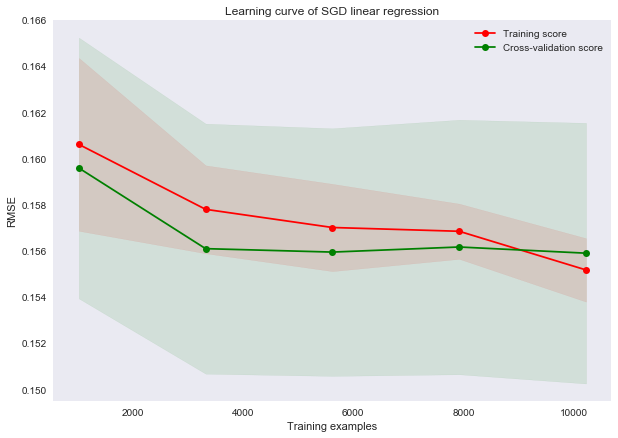

<module 'matplotlib.pyplot' from '/Users/dnemi/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [195]:
plot_learning_curve(sgd_opt, 'Learning curve of SGD linear regression', X, y,
                    save_name='sgd_learning_curve.png')


### Decision Tree Regression ###

In [33]:
tree_param_grid = [{'max_depth': [2, 4, 6, 8, 10, 15, 20, 30, 50], 'min_samples_split': [2, 4, 6], 
                    'min_samples_leaf': [1, 2, 4, 6]}]


tree_opt = full_train_test_fit_score(DecisionTreeRegressor(random_state=rnd_state), 
                                                   tree_param_grid, X, X_test, y, y_test,
                                                   data_dir, 'Decision Tree Regression', verbose=False)



Best params: {'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 6}

MODEL: Decision Tree Regression

TRAIN RESULTS:
RMSE: 0.024046923256275023

VALIDATION RESULTS:
0.05796182963353778

TEST RESULTS:
RMSE: 0.18553493094554102




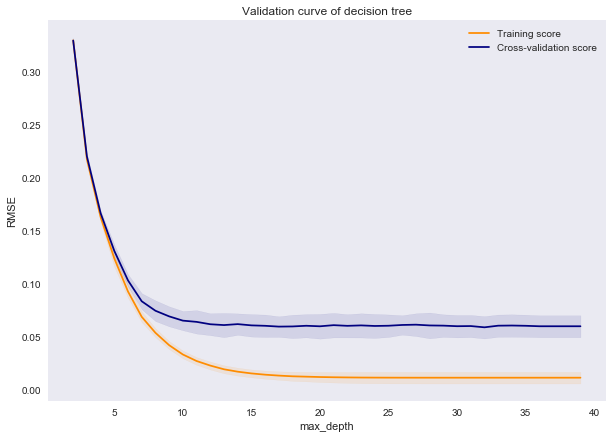

<module 'matplotlib.pyplot' from '/Users/dnemi/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [34]:
plot_validation_curve(DecisionTreeRegressor(random_state=rnd_state, min_samples_leaf = 1, min_samples_split= 2), 
                      'Validation curve of decision tree', 
                      X, y, 
                      'max_depth', 
                      param_range = list(range(2,40)),#[2, 3, 4, 5, 8, 10, 20, 30, 50],
                     save_name='dtree_validation_curve.png')

/Users/dnemi/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:811: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):


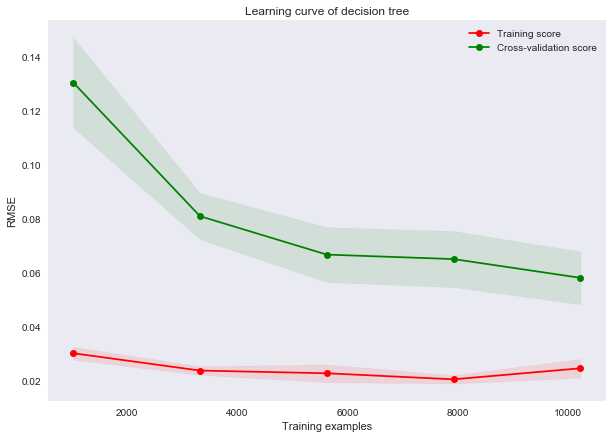

<module 'matplotlib.pyplot' from '/Users/dnemi/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [35]:
plot_learning_curve(tree_opt, 'Learning curve of decision tree', X, y,
                    save_name='dtree_learning_curve.png')

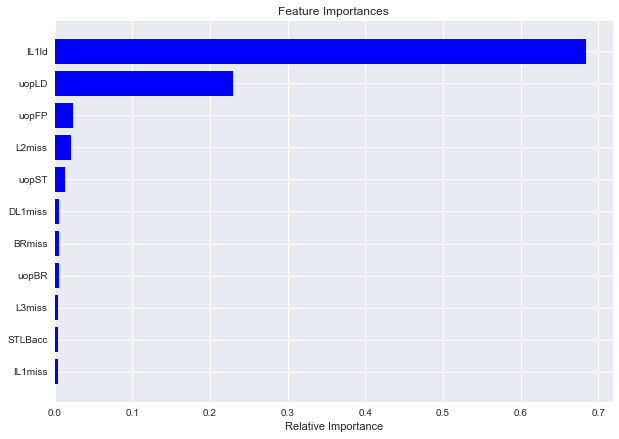

In [37]:
plot_feature_importances(tree_opt,X,save_name='dtree_feature_importances.png')


### Random Forest Regressor ###

In [38]:
forest_param_grid = [
    # try 20 (4×5) combinations of hyperparameters
    {'n_estimators': [3, 10, 20, 30], 'max_features': [ 2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10, 20, 30], 'max_features': [2, 4, 6, 8]},
  ]

forest_opt = full_train_test_fit_score(RandomForestRegressor(random_state=rnd_state), 
                                                   forest_param_grid, X, X_test, y, y_test,
                                                   data_dir, 'Random Forest Regression', verbose=False)



Best params: {'bootstrap': False, 'max_features': 2, 'n_estimators': 30}

MODEL: Random Forest Regression

TRAIN RESULTS:
RMSE: 0.012306967873848947

VALIDATION RESULTS:
0.038621976945647826

TEST RESULTS:
RMSE: 0.2143002249609581




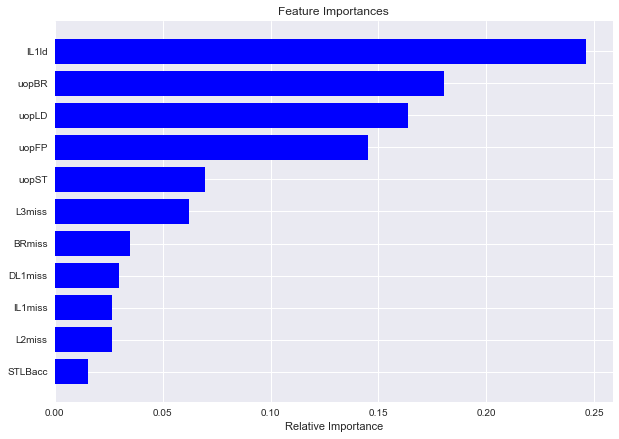

In [39]:
plot_feature_importances(forest_opt,X,save_name='rforest_feature_importances.png')

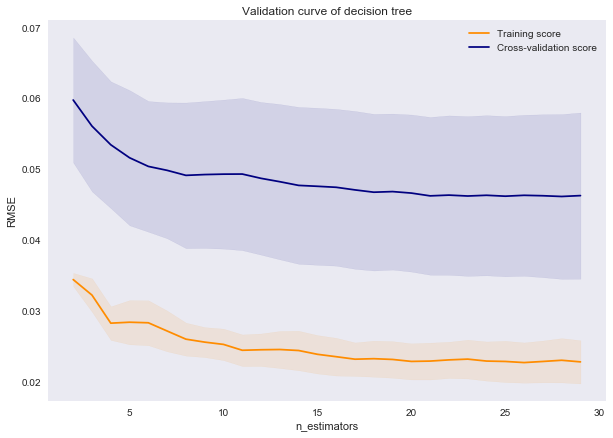

<module 'matplotlib.pyplot' from '/Users/dnemi/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [40]:
plot_validation_curve(RandomForestRegressor(random_state=rnd_state), 
                      'Validation curve of decision tree', 
                      X, y, 
                      'n_estimators', 
                      param_range = list(range(2,30)),#[2, 3, 4, 5, 8, 10, 20, 30, 50],
                     save_name='rforest_validation_curve.png')

/Users/dnemi/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:811: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):


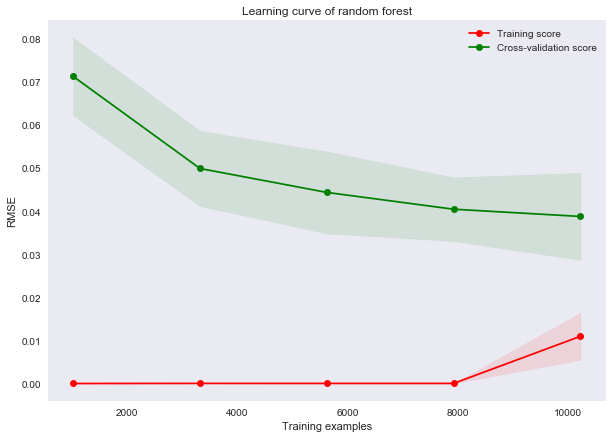

<module 'matplotlib.pyplot' from '/Users/dnemi/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [41]:
plot_learning_curve(forest_opt, 'Learning curve of random forest', X, y,
                    save_name='rforest_learning_curve.png')

### Support Vector Regression ###

In [ ]:
svr_param_grid = [
    #{'kernel':('linear', 'rbf'), 'C':[1, 5, 10], 'epsilon': [0.03, 0.1, 0.2]}
    {'kernel':('linear', 'rbf'), 'C':[1], 'epsilon': [0.1]}
  ]

svr_opt, svr_opt_ratio = full_train_test_fit_score(SVR(), 
                                                   svr_param_grid, X, X_test, y, y_test,
                                                   data_dir, 'Support Vector Regressor', verbose=False)

### Neural Network: Multilayer Perceptron Regression ###

In [42]:
mlp_param_grid = [
    {'hidden_layer_sizes':[(2,), (6,), (25,), (100,), (6,6), (25,5), (10,10)], 
     'activation':['relu'],
     'max_iter': [200, 400, 1000],
     'early_stopping' : [False, True],
    'alpha': [0.001, 0.01, 0.1]}
  ]

mlp_opt = full_train_test_fit_score(MLPRegressor(random_state = rnd_state), 
                                                   mlp_param_grid, X, X_test, y, y_test,
                                                   data_dir, 'MLP Regressor', verbose=True)


Best params: {'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (100,), 'max_iter': 400}
Results for gridsearch
0.11646970997644047 {'activation': 'relu', 'alpha': 0.001, 'early_stopping': False, 'hidden_layer_sizes': (2,), 'max_iter': 200}
0.11646970997644047 {'activation': 'relu', 'alpha': 0.001, 'early_stopping': False, 'hidden_layer_sizes': (2,), 'max_iter': 400}
0.11646970997644047 {'activation': 'relu', 'alpha': 0.001, 'early_stopping': False, 'hidden_layer_sizes': (2,), 'max_iter': 1000}
0.11956641006491166 {'activation': 'relu', 'alpha': 0.001, 'early_stopping': False, 'hidden_layer_sizes': (6,), 'max_iter': 200}
0.11956641006491166 {'activation': 'relu', 'alpha': 0.001, 'early_stopping': False, 'hidden_layer_sizes': (6,), 'max_iter': 400}
0.11956641006491166 {'activation': 'relu', 'alpha': 0.001, 'early_stopping': False, 'hidden_layer_sizes': (6,), 'max_iter': 1000}
0.08398117598499814 {'activation': 'relu', 'alpha': 0.001, 'early_stopping': F

0.06490727769079381

TEST RESULTS:
RMSE: 0.16319139183049344




In [ ]:
plot_validation_curve(MLPRegressor(random_state = rnd_state), 
                      'Validation curve of ANN', 
                      X, y, 
                      'hidden_layer_sizes', 
                      param_range = [(2,), (6,), (25,), (100,), (6,6), (25,5), (10,10)],
                     save_name='ann_validation_curve.png', is_ann=True)

/Users/dnemi/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:811: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(train_sizes_abs.dtype, np.float):


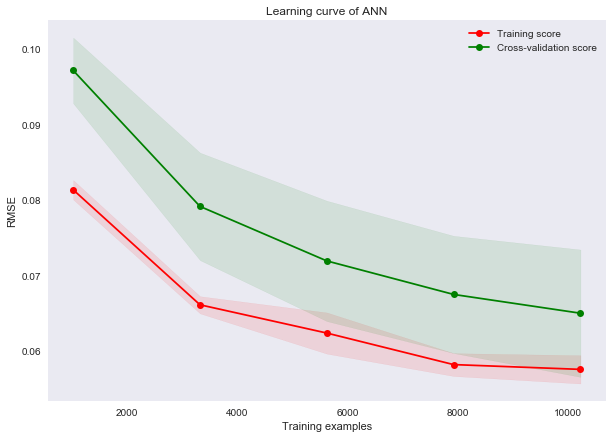

<module 'matplotlib.pyplot' from '/Users/dnemi/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [44]:
plot_learning_curve(mlp_opt, 'Learning curve of ANN', X, y,
                    save_name='ann_learning_curve.png')

### K Nearest Neighbors Predictor ###

In [51]:
knn_param_grid = [
    {'n_neighbors':range(2,30),
    'weights': ['uniform', 'distance']}
  ]

knn_opt = full_train_test_fit_score(KNeighborsRegressor(),
                                    knn_param_grid, X, X_test, y, y_test,
                                    data_dir, 'K Nearest Neighbors Regressor', verbose=True)



Best params: {'n_neighbors': 5, 'weights': 'distance'}
Results for gridsearch
0.04967120826269716 {'n_neighbors': 2, 'weights': 'uniform'}
0.048978072776335195 {'n_neighbors': 2, 'weights': 'distance'}
0.04658613285503314 {'n_neighbors': 3, 'weights': 'uniform'}
0.04475941119057313 {'n_neighbors': 3, 'weights': 'distance'}
0.04707587902758247 {'n_neighbors': 4, 'weights': 'uniform'}
0.04383918718203065 {'n_neighbors': 4, 'weights': 'distance'}
0.04817729487152433 {'n_neighbors': 5, 'weights': 'uniform'}
0.04377853245744313 {'n_neighbors': 5, 'weights': 'distance'}
0.049057104649255244 {'n_neighbors': 6, 'weights': 'uniform'}
0.04408862300950268 {'n_neighbors': 6, 'weights': 'distance'}
0.050681561777914066 {'n_neighbors': 7, 'weights': 'uniform'}
0.04496824718615397 {'n_neighbors': 7, 'weights': 'distance'}
0.052584355614160035 {'n_neighbors': 8, 'weights': 'uniform'}
0.04605510825546811 {'n_neighbors': 8, 'weights': 'distance'}
0.05383154207405039 {'n_neighbors': 9, 'weights': 'unifo

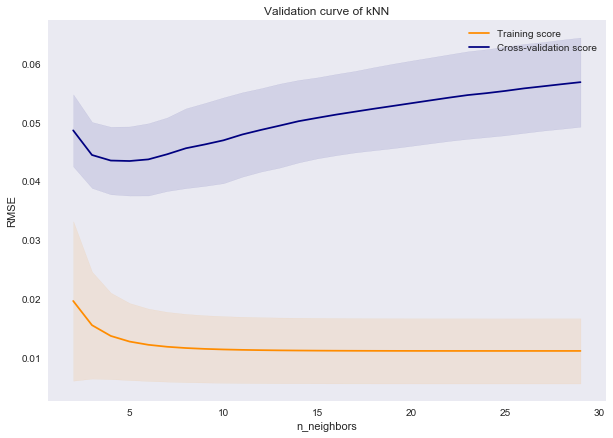

<module 'matplotlib.pyplot' from '/Users/dnemi/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [50]:
plot_validation_curve(KNeighborsRegressor(weights= 'distance'), 'Validation curve of kNN', 
                      X, y, 
                      'n_neighbors', 
                      param_range = range(2,30),
                     save_name='knn_validation_curve.png')